# Test build 2

- based on __form, product, state, NTEE__
- using __fastai__ library

In [1]:
import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

import pandas as pd
from fastai.tabular.all import *
from fastai.losses import L1LossFlat, MSELossFlat
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

# modeling conversion

## load & prep dataset

In [5]:
# pull data
df = pd.read_csv("seg_state.forms.csv")

# if one hot encoding slips in, remove
if 'segment_E' in df.columns:
    for c in [col for col in df.columns if 'segment_' in col]:
        df.drop(c, axis=1, inplace=True)
        
if 'created' in df.columns:
    df.drop('created', axis=1, inplace=True)

df.head(2)

,form,week,pageviews,count_all,vol_all,count_onetime,count_recurring,avg_onetime,avg_recurring,product,ntee,state,conversion_ot,conversion_rec
0,93241,2021-04-26 00:00:00,448,0.0,0.00,0.0,0.0,NaN,NaN,1.0,B - Educational Institutions,VA,0.0,0.0
1,218178,2018-04-02 00:00:00,101872,1.0,208.34,0.0,0.0,0.0,0.0,1.0,O - Youth Development,CA,0.0,0.0


In [9]:
targets = ['conversion_ot', 'conversion_rec', 'avg_onetime', 'avg_recurring']
targets = ['conversion_rec', 'avg_onetime', 'avg_recurring']
target = 'conversion_ot'

drop_cols = ['form', 'week', 'pageviews', 'count_all', 'vol_all', 
             'count_onetime', 'count_recurring', 'avg_onetime', 'avg_recurring']

In [10]:
df_final = df.drop(drop_cols, axis=1)

In [11]:
df_final.head(2)

,product,ntee,state,conversion_ot,conversion_rec
0,1.0,B - Educational Institutions,VA,0.0,0.0
1,1.0,O - Youth Development,CA,0.0,0.0


In [12]:
df_final.isna().sum()

product             636
ntee              51866
state              1416
conversion_ot         0
conversion_rec        0
dtype: int64

In [15]:
print(len(df_final[df_final['state'].isna()]) / len(df_final))
df_final[df_final['state'].isna()].head(2)

0.0008826741536052501


,product,ntee,state,conversion_ot,conversion_rec
5,NaN,NaN,NaN,0.0,0.0
10,NaN,NaN,NaN,0.0,0.0


In [16]:
print(len(df_final[df_final['ntee'].isna()]) / len(df_final))
df_final[df_final['ntee'].isna()].head(2)

0.03233105766305784


,product,ntee,state,conversion_ot,conversion_rec
5,NaN,NaN,NaN,0.0,0.0
10,NaN,NaN,NaN,0.0,0.0


In [17]:
len_all = len(df_final)
len_nadropped = len(df_final.dropna())

print("{:,} original rows".format(len_all))
print("{:,} rows dropna; {:.1f}%".format(len_nadropped, (len_nadropped / len_all) * 100.))

1,604,216 original rows
1,552,338 rows dropna; 96.8%


Being a bit lazy here and dropping NA's because the subset is so small, but it's worth double checking why these are NA

In [18]:
df_final = df_final.dropna()

In [26]:
print("{:,} observations".format(len(df_final)))
df_final[['state', 'ntee', 'product']].nunique()

1,552,338 observations


state      63
ntee       30
product     5
dtype: int64

In [94]:
def translate_product(p):
    if p == 1:
        return 'qgiv'
    elif p == 2:
        return 'barnstorm'
    elif p == 3:
        return 'p2p'
    elif p == 4:
        return 'agg'
    elif p == 5:
        return 'auction'
    else:
        return p

df_final['product'] = df_final['product'].apply(translate_product)
df_final['product'].unique()

array(['qgiv', 'p2p', 'auction', 'barnstorm', 'agg'], dtype=object)

## modeling

Embedding dimensions:

- state: 10
- segment: 5
- product: 2

Trainings:

1. 25 epochs: train: 21.14 - 5.46; valid: 9.95 - 9.89
2. 25 epochs: train: 5.41 - 8.63; valid: 28.88 - 28.80
3. 25 epochs: train: 61.03 - 23.57; valid: 8.31 - 8.23 (train immediately fell to 4.96 on the second epoch, 4.7 at epoch 21)
4. 25 epochs: train: 5.21 - 8.59; valid: 8.92 - 8.86
5. 25 epochs: train: 6.02 - 12.60; valid: 8.17 - 8.10
6. 25 epochs: train: 4.62 - 15.48; valid: 6.28 - 6.20 (changes to embeddings)
7. 25 epochs: train: 13.66 - 6.66; valid: 8.49 - 8.44
8. 25/25/25/25 epochs: train: 10.43 - 9.03 - 6.89 - 22.24; valid: 11.66 - 11.58 - 11.60 - 11.60 (valid rose to 11.63 before falling to 11.60)
9. 50 epochs: train: 8.11 - 7.07; valid: 12.36 - 12.27

Notes:

- continuing theme seen with organization trainings, train loss varying as is normal but validation losses move much less wildly occasionally popping above the prior value but generally falling
- losses (train & validation) are noticeably smaller than on the organization side; this could be accounted for by:
    - greater training data size
    - division by product, granting lower variability in conversion numbers
    - simply having the 3rd dimension (product) grants a more complex model, thus capable of learning more complex relationships
- the validation loss continues to never move dramatically in either direction throughout all of the trainings, so I believe we are seeing the same effect as with org's for the same reasons: the train/test split may be playing an overwhelming role in validation loss
- multiple runs doesn't seem to be helpful

In [146]:
# prep dataset
cont, cat = cont_cat_split(df_final.drop('conversion_rec', axis=1), dep_var=target)
procs = [Categorify, Normalize]
splits = RandomSplitter()(df_final.drop('conversion_rec', axis=1))

In [147]:
to_nn = TabularPandas(df_final.drop('conversion_rec', axis=1), procs, cat, cont,
                      splits=splits, y_names=target)

In [148]:
dls = to_nn.dataloaders(512, device=device)

In [149]:
learn = tabular_learner(dls, layers=[250], emb_szs={'state': 30, 'ntee': 10, 'product': 5},  n_out=1, 
                        loss_func=F.mse_loss, metrics=F.l1_loss)

In [150]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,l1_loss,time
0,8.107784,12.360284,0.330505,00:26


In [151]:
learn.fit_one_cycle(50, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,l1_loss,time
0,5.936481,12.343731,0.340605,00:26
1,11.387004,12.334119,0.331513,00:26
2,13.833683,12.325745,0.340707,00:27
3,16.533447,12.314196,0.334032,00:27
4,12.512107,12.300392,0.350333,00:27
5,5.663697,12.321453,0.356904,00:27
6,4.187810,12.323051,0.352679,00:26
7,8.902748,12.321474,0.347110,00:26
8,113.568420,12.350842,0.377010,00:26
9,5.565358,12.309296,0.370058,00:27


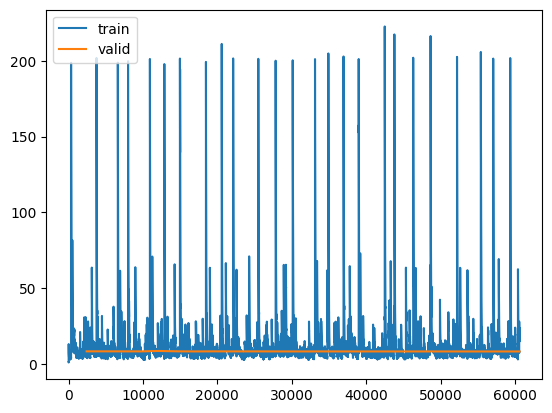

In [48]:
learn.recorder.plot_loss()

In [124]:
#learn.save('forms.6')

Path('models/forms.6.pth')

In [125]:
learn.embeds

ModuleList(
  (0): Embedding(6, 5)
  (1): Embedding(31, 10)
  (2): Embedding(64, 30)
)

In [126]:
learn.dls.cat_names

(#3) ['product','ntee','state']